# 1. Importing necessarry modules and configuration

## 1.1. Importing necessarry EDA and processing modules

In [1]:
import numpy as np # for numarical operations
import pandas as pd # for dataframe operations
import os #files processing
import seaborn as sns # for visualizations
import matplotlib.pyplot as plt # for visualizations
from scipy import stats # for statistics
import warnings # to manage warnings

## 1.2. Model and metrics based modules

In [2]:
from sklearn.model_selection import train_test_split # for train test split of data
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV #hyperparameter tuning
from sklearn.metrics import roc_auc_score #scoring metric
from sklearn.model_selection import StratifiedKFold # for K-fold validation
from xgboost import XGBClassifier # main classifier
from sklearn.model_selection import cross_val_score, KFold # for K-fold validation
from sklearn.preprocessing import OneHotEncoder #for one hot encoding

## 1.3. Configuration

In [3]:
#for getting filenames
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
#to ignore warnings while modeling
warnings.filterwarnings('ignore')  

/kaggle/input/robi-datathon-2-pre-assessment/sample_submission.csv
/kaggle/input/robi-datathon-2-pre-assessment/train.csv
/kaggle/input/robi-datathon-2-pre-assessment/test.csv


# 2. Data Loading and Primary Observation

## 2.1. Loading train and test data

In [4]:
train_df=pd.read_csv("/kaggle/input/robi-datathon-2-pre-assessment/train.csv")
test=pd.read_csv("/kaggle/input/robi-datathon-2-pre-assessment/test.csv")

## 2.2. Checking training data

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28322 entries, 0 to 28321
Data columns (total 36 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28322 non-null  object 
 1   gender  28322 non-null  object 
 2   s11     28322 non-null  object 
 3   s12     28322 non-null  object 
 4   s13     28322 non-null  int64  
 5   s16     28322 non-null  object 
 6   s17     28322 non-null  object 
 7   s18     28322 non-null  object 
 8   s48     28322 non-null  int64  
 9   s52     28322 non-null  object 
 10  s53     28322 non-null  object 
 11  s54     2628 non-null   object 
 12  s55     3206 non-null   object 
 13  s56     0 non-null      float64
 14  s57     0 non-null      float64
 15  s58     28322 non-null  object 
 16  s59     0 non-null      float64
 17  s69     28322 non-null  object 
 18  s70     28322 non-null  object 
 19  s71     28322 non-null  object 
 20  n1      28322 non-null  float64
 21  n2      28322 non-null  float64
 22

#### Observation : 
- Some data is missing, cleaning required.

## 2.3. Checking Test Data

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28322 entries, 0 to 28321
Data columns (total 36 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28322 non-null  object 
 1   gender  28322 non-null  object 
 2   s11     28322 non-null  object 
 3   s12     28322 non-null  object 
 4   s13     28322 non-null  int64  
 5   s16     28322 non-null  object 
 6   s17     28322 non-null  object 
 7   s18     28322 non-null  object 
 8   s48     28322 non-null  int64  
 9   s52     28322 non-null  object 
 10  s53     28322 non-null  object 
 11  s54     2628 non-null   object 
 12  s55     3206 non-null   object 
 13  s56     0 non-null      float64
 14  s57     0 non-null      float64
 15  s58     28322 non-null  object 
 16  s59     0 non-null      float64
 17  s69     28322 non-null  object 
 18  s70     28322 non-null  object 
 19  s71     28322 non-null  object 
 20  n1      28322 non-null  float64
 21  n2      28322 non-null  float64
 22

#### Observation : 
- Some data is missing, cleaning required.

# 3. Data Configuration

## 3.1. Getting target column

In [7]:
target=train_df['label']
df=train_df.drop('label',axis=1)

## 3.2. Getting numerical columns

In [8]:
numaric_columns=list(df.select_dtypes(include=np.number).columns)
print("Numaric columns ("+str(len(numaric_columns))+") :",", ".join(numaric_columns))

Numaric columns (20) : s13, s48, s56, s57, s59, n1, n2, n3, n4, n5, n6, n7, n8, n9, n10, n11, n12, n13, n14, n15


## 3.3. Getting categorical columns

In [9]:
cat_columns=df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns ("+str(len(cat_columns))+") :",", ".join(cat_columns))

Categorical columns (15) : id, gender, s11, s12, s16, s17, s18, s52, s53, s54, s55, s58, s69, s70, s71


# 4. EDA, Wrangling, Cleaning

## 4.1. Analyzing Target column

### 4.1.1. Number of Targets and their size

Text(0.5, 1.0, 'Number of Targets and size')

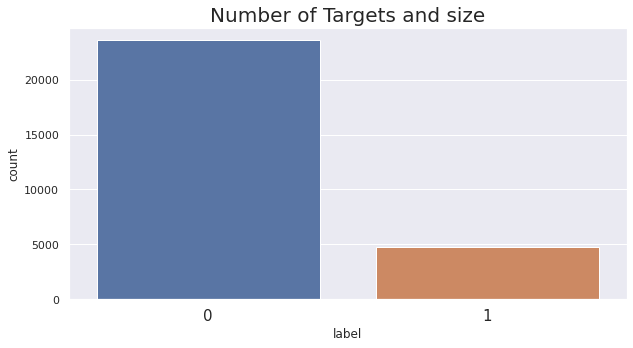

In [10]:
sns.set(rc={'figure.figsize':(10,5)}) #setting plot size
plt.xticks(fontsize=15)
p=sns.countplot(target,order=[0,1])
p.axes.set_title("Number of Targets and size",fontsize=20)

In [11]:
print("Number of label 0 is ",23562/4760,'times higher than label 1')

Number of label 0 is  4.95 times higher than label 1


#### Observation : 
- Target variable is highly skewed to zero.
- This can cause both Type I and Type II errors.
- But, downsampling this will cause us lose a lot of data, so, we will focus on regularization more during modeling.

## 4.2. Analyzing Numaric Columns

### 4.2.1. Checking numerical values - Missing values

In [12]:
ndf=df[numaric_columns]
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28322 entries, 0 to 28321
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s13     28322 non-null  int64  
 1   s48     28322 non-null  int64  
 2   s56     0 non-null      float64
 3   s57     0 non-null      float64
 4   s59     0 non-null      float64
 5   n1      28322 non-null  float64
 6   n2      28322 non-null  float64
 7   n3      28322 non-null  int64  
 8   n4      28322 non-null  float64
 9   n5      28322 non-null  float64
 10  n6      28322 non-null  float64
 11  n7      28322 non-null  float64
 12  n8      28322 non-null  float64
 13  n9      28322 non-null  float64
 14  n10     28322 non-null  float64
 15  n11     28322 non-null  float64
 16  n12     28322 non-null  int64  
 17  n13     28322 non-null  int64  
 18  n14     28322 non-null  float64
 19  n15     28322 non-null  int64  
dtypes: float64(14), int64(6)
memory usage: 4.3 MB


#### Observation : 
- "s56","s57","s59" - is totally empty, so, dropping those.

In [13]:
ndf=ndf.drop(["s56","s57","s59"],axis=1) #dropped
numaric_columns= list(set(numaric_columns).difference(set(["s56","s57","s59"]))) #dropped from column name list too

### 4.2.2. Checking numerical values - Observing

In [14]:
ndf.head()

,s13,s48,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,n15
0,1,0,16.144666,1.989441,2,2.318385,-32.839277,0.017176,-9.126056,1.732291,3.698504,4.804517,1.544484,0,0,0.631220,5
1,1,1,7.144558,0.844866,3,6.197768,-32.576597,0.013857,-9.098287,1.505885,6.791357,6.110416,1.712354,0,0,0.392746,3
2,1,0,6.923236,1.042018,6,7.824401,-32.510544,0.013943,-9.234894,1.503828,4.109685,3.953226,1.804260,0,0,0.222537,2
3,1,0,5.749840,0.781439,2,8.256767,-32.398679,0.010387,-9.378025,1.485863,7.265876,4.559419,1.537645,0,0,0.154409,4
4,1,1,14.771959,1.248188,3,2.300011,-32.396746,0.016289,-9.261962,1.619210,3.737647,4.052003,1.637831,0,1,0.737560,1


#### Observation : 
- Looks good now.

### 4.2.3. Boxplot - Checking Distributions

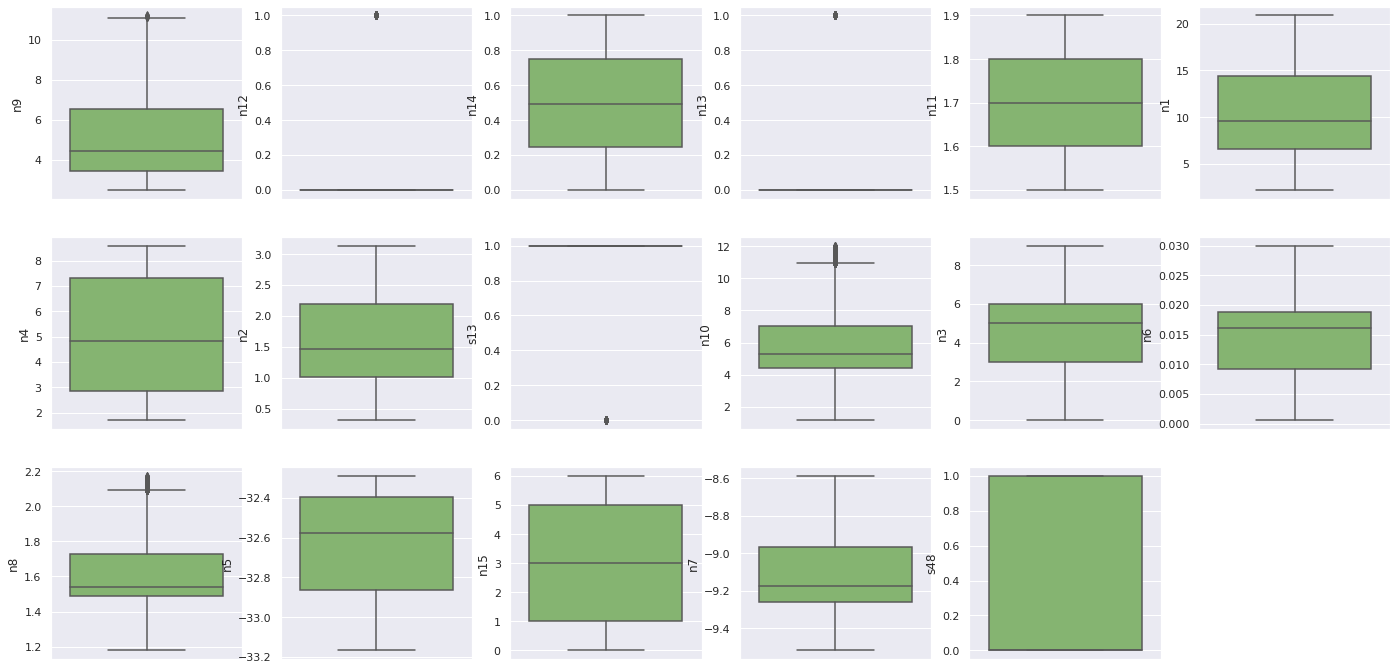

In [15]:
sns.set(rc={'figure.figsize':(24,12)}) #setting plot size
for i, column in enumerate(numaric_columns, 1):
    plt.subplot(3,6,i)
    p=sns.boxplot(y=column,data=ndf,palette='summer')

#### Observation : 
- s48 has merginal values, other that that, distributions seems ok.

### 4.2.4. Histplot - Checking Distributions with Targets

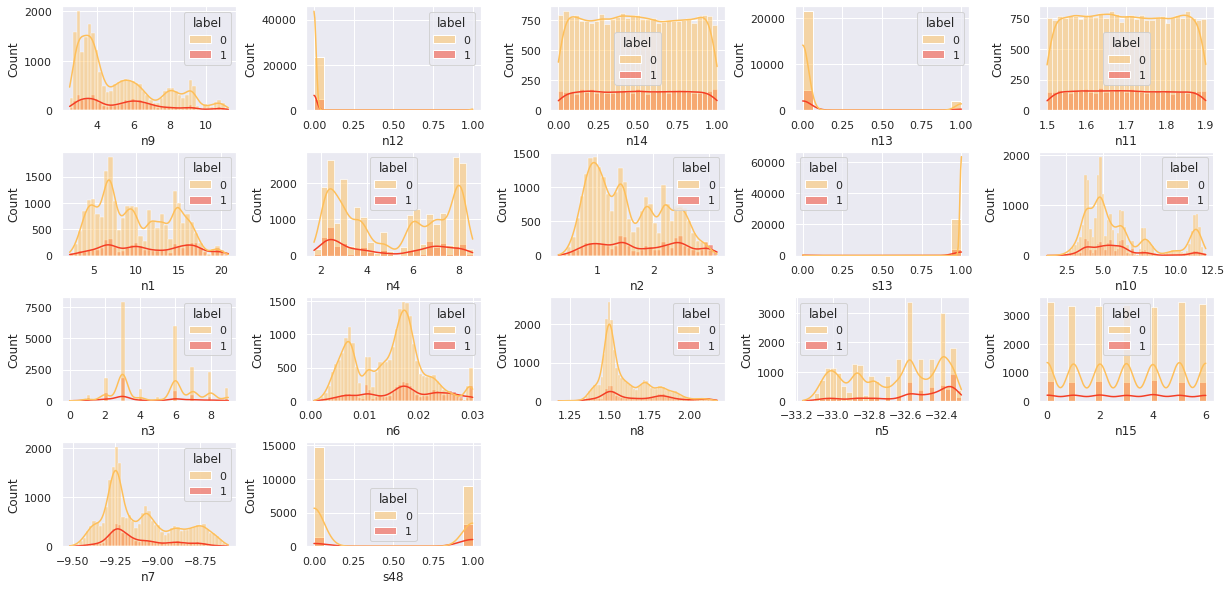

In [16]:
sns.set(rc={'figure.figsize':(20,15)}) #setting plot size
plt.subplots_adjust(left=0.1,
                    bottom=0.4, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i, column in enumerate(numaric_columns, 1):
    plt.subplot(4,5,i)
    p=sns.histplot(x=column,data=ndf,hue=target,stat='count',kde=True,palette='YlOrRd');

#### Observations:
- As 0 is prsent 4.5 times than 1; this is expected.
- n12, s13, n13 - their distribution seems quite unnatural.
- Others are decent.
- n15 is not continuous.
- s48 has merginal values only.

### 4.2.5. Scatterplot with Target

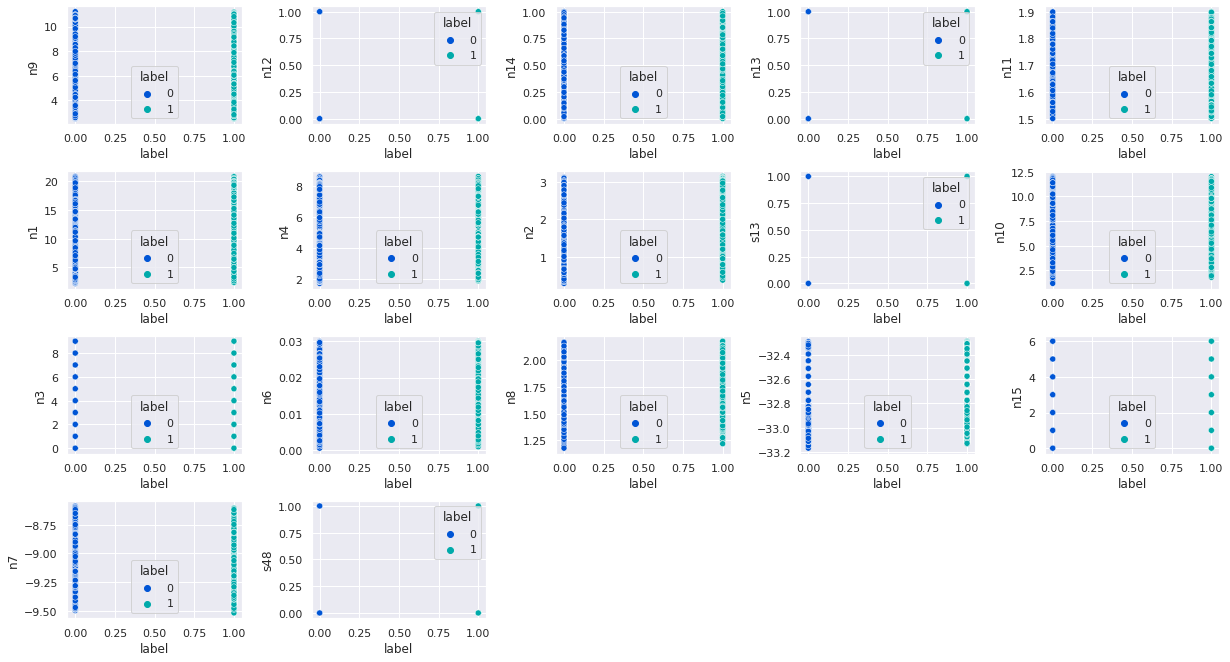

In [17]:
sns.set(rc={'figure.figsize':(20,17)}) #setting plot size
plt.subplots_adjust(left=0.1,
                    bottom=0.4, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i, column in enumerate(numaric_columns, 1):
    plt.subplot(4,5,i)
    p=sns.scatterplot(y=ndf[column],x=target,hue=target,palette='winter');

#### Observations:
- Values seem distributed well into labels; no visible linear seerations possible.

#### 4.2.6. Adding the id row for later operations

In [18]:
ndf['id']=df['id']

## 4.3. Analyzing Categorical Columns

### 4.3.1. Checking missing values

In [19]:
cat_columns.remove('id')
cdf=df[cat_columns]
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28322 entries, 0 to 28321
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gender  28322 non-null  object
 1   s11     28322 non-null  object
 2   s12     28322 non-null  object
 3   s16     28322 non-null  object
 4   s17     28322 non-null  object
 5   s18     28322 non-null  object
 6   s52     28322 non-null  object
 7   s53     28322 non-null  object
 8   s54     2628 non-null   object
 9   s55     3206 non-null   object
 10  s58     28322 non-null  object
 11  s69     28322 non-null  object
 12  s70     28322 non-null  object
 13  s71     28322 non-null  object
dtypes: object(14)
memory usage: 3.0+ MB


In [20]:
cdf.head()

,gender,s11,s12,s16,s17,s18,s52,s53,s54,s55,s58,s69,s70,s71
0,M,Y,N,D,D,B,1,,NaN,kK,B,x,op: D,b
1,M,Y,Y,D,D,B,1,,NaN,NaN,B,x,op: D,b
2,M,Y,Y,D,D,B,1,,NaN,NaN,B,x,op: D,b
3,F,Y,Y,D,D,B,1,,NaN,NaN,B,x,op: D,b
4,M,N,Y,B,D,D,l,,NaN,NaN,B,~1,op: D,d


#### Observations:
- s54 and s55 has very few values compared to others.
- We tested it by imputing eith iterative imputers, but the result is not steady. So, we are droping these.

In [21]:
cdf=cdf.drop(['s54','s55'],axis=1)
cat_columns.remove('s54')
cat_columns.remove('s55')

### 4.3.2. Checking distributions

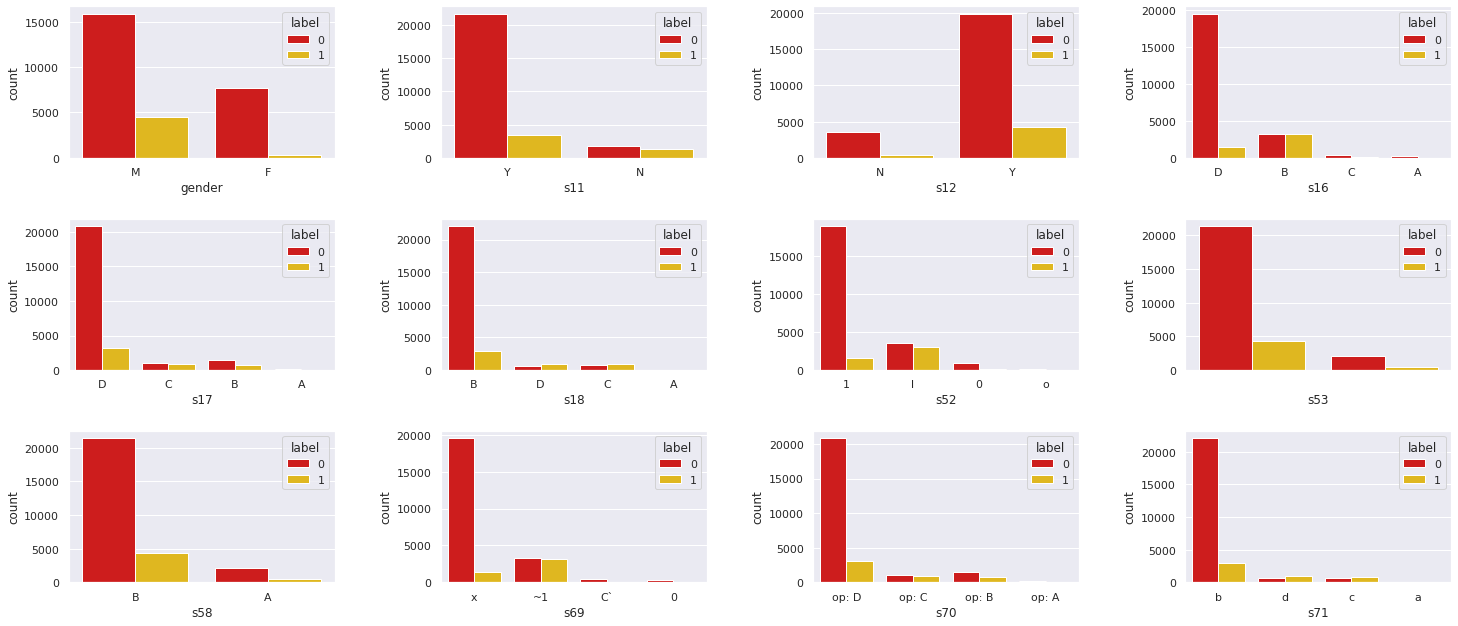

In [22]:
sns.set(rc={'figure.figsize':(24,16)}) #setting plot size
plt.subplots_adjust(left=0.1,
                    bottom=0.4, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i, column in enumerate(cat_columns, 1):
    plt.subplot(3,4,i)
    p=sns.countplot(cdf[column],hue=target,palette='hot'); #countplot

#### Observations:
- some categories' counts are very high. So, the model can generate bias; so we will be keeping our eyes on these by tuning hyperparameters.

### 4.3.2. Checking more infos

In [23]:
cdf.describe(include=['object'])

,gender,s11,s12,s16,s17,s18,s52,s53,s58,s69,s70,s71
count,28322,28322,28322,28322,28322,28322,28322,28322,28322,28322,28322,28322
unique,2,2,2,4,4,4,4,2,2,4,4,4
top,M,Y,Y,D,D,B,1,,B,x,op: D,b
freq,20396,25112,24227,21028,24013,25010,20524,25752,25760,21028,24013,25010


#### Observations:
- highest unique value count is 4; One-hot Encoder is easilyy appicable

# 5. Feature Engineering

## 5.1. One hot encoder for categorical variables

In [24]:
onehot_encoder = OneHotEncoder(sparse=False) #encoder class
onehot_encoded = onehot_encoder.fit_transform(cdf) #fit-transforming cat_df
ocdf=pd.DataFrame(onehot_encoded) #into df
ocdf['id']=df['id']  #adding id
ocdf.head() #checking if it is ok

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,id
0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,b'gAAAAABinOicS09vrmgh0_JyEHihI13ptO0rCyHP7l76...
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,b'gAAAAABinOiWGC1WhR6WYP0DA5ssGv9rIekrWUwCdJ8F...
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,b'gAAAAABinOibTcOBFIVeA4nVF3FuFz_QX3ZlPPFc21gS...
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,b'gAAAAABinOig-g3-Q1ggjlMhfUSdn21Aj5yVVeVvXbis...
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,b'gAAAAABinOiXdoaNUzihOSbyY1tjWtd5EgMaXkkvH6SV...


#### Observations:
- Looks great!

# 6. Finalizing the dataset for modeling

## 6.1. For Train Data

### 6.1.1. Merging numarical and categorical values

In [25]:
fdf=pd.merge(ndf,ocdf, on='id', how='outer') #merging numerical and categorical columns based on id

### 6.1.2. Checking merged dataset

In [26]:
fdf.head()

,s13,s48,n1,n2,n3,n4,n5,n6,n7,n8,...,28,29,30,31,32,33,34,35,36,37
0,1,0,16.144666,1.989441,2,2.318385,-32.839277,0.017176,-9.126056,1.732291,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1,1,7.144558,0.844866,3,6.197768,-32.576597,0.013857,-9.098287,1.505885,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,0,6.923236,1.042018,6,7.824401,-32.510544,0.013943,-9.234894,1.503828,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,0,5.749840,0.781439,2,8.256767,-32.398679,0.010387,-9.378025,1.485863,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1,1,14.771959,1.248188,3,2.300011,-32.396746,0.016289,-9.261962,1.619210,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [27]:
fdf=fdf.drop('id',axis=1) #droping id, before sending into model
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28322 entries, 0 to 28321
Data columns (total 55 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s13     28322 non-null  int64  
 1   s48     28322 non-null  int64  
 2   n1      28322 non-null  float64
 3   n2      28322 non-null  float64
 4   n3      28322 non-null  int64  
 5   n4      28322 non-null  float64
 6   n5      28322 non-null  float64
 7   n6      28322 non-null  float64
 8   n7      28322 non-null  float64
 9   n8      28322 non-null  float64
 10  n9      28322 non-null  float64
 11  n10     28322 non-null  float64
 12  n11     28322 non-null  float64
 13  n12     28322 non-null  int64  
 14  n13     28322 non-null  int64  
 15  n14     28322 non-null  float64
 16  n15     28322 non-null  int64  
 17  0       28322 non-null  float64
 18  1       28322 non-null  float64
 19  2       28322 non-null  float64
 20  3       28322 non-null  float64
 21  4       28322 non-null  float64
 22

#### Observations:
- Looks great! No missing values or categorical values.

## 6.2. For Test Data

Here we developed a function to process the data for test df. It includes all the precrocessing we have done before, applied all at once in test df.

In [28]:
def process_df(df):
    ndf=pd.DataFrame(df[numaric_columns],index=df['id']).reset_index()  #taking numarical cols
    
    cdf=df[cat_columns] #taking categorical cols
    onehot_encoder = OneHotEncoder(sparse=False) # encoder
    onehot_encoded = onehot_encoder.fit_transform(cdf) #encoding
    ocdf=pd.DataFrame(onehot_encoded,index=df['id']).reset_index() #getting into df
    
    fdf=pd.merge(ndf,ocdf, on='id', how='outer') #merging both on id
    fdf=fdf.drop('id',axis=1) #droping id
    return fdf #returning output df

# 7. Modeling (XGBoost)

## 7.1. Train-test split

In [29]:
train_X, test_X, train_Y, test_Y = train_test_split(fdf, target, test_size=0.3,random_state=41) #30% for test, 70% for train

- random state 41 is used for reproducibility.

## 7.2. XGBClassifier Model
- We tuned with model with GridSearch and Manual hyperparameter tuning. It took 8 hours, so we just took the parameters and placed into single model for saving time. 
- reg_alpha and reg_lambda are used for penalizing Type- 1 and 2 errors. The values are quite high comparing defaults, meanng high penalization for these type of errors to avoid biases.
- GPU boosting is used.
- random state 41 is used for reproducibility.

In [30]:
xgb_cls = XGBClassifier(learning_rate=0.05,subsample=0.8,min_child_weight=7,max_depth=3,gamma=0.5,colsample_bytree=0.7, n_estimators=450, objective='binary:logistic'
                        ,random_state=41,tree_method='gpu_hist',reg_lambda=100,reg_alpha=80) #model
xgb_cls.fit(train_X, train_Y) #fitting train data

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=450,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=41,
              reg_alpha=80, reg_lambda=100, ...)

## 7.3 CV and K-Fold 

In [31]:
scores = cross_val_score(xgb_cls, train_X, train_Y, cv=10) #cross validatiob scores, cv=10
kfold = KFold(n_splits=10, shuffle=True) #developing kFold
kf_cv_scores = cross_val_score(xgb_cls, test_X, test_Y, cv=kfold ) #KFold scores

## 7.4 CV and K-Fold scores

In [32]:
print("Mean cross-validation score: %.5f" % scores.mean())
print("K-fold CV average score: %.5f" % kf_cv_scores.mean());
print("\n\n")
print("All scores :\n",scores)
print("KFold scores :\n",kf_cv_scores)

Mean cross-validation score: 0.87667
K-fold CV average score: 0.87325



All scores :
 [0.87544125 0.88804841 0.88300555 0.8734241  0.86535552 0.87991927
 0.87638749 0.86932392 0.87436932 0.8814329 ]
KFold scores :
 [0.88588235 0.86352941 0.88470588 0.87058824 0.85294118 0.87647059
 0.88117647 0.86572438 0.86572438 0.88574794]


## 7.5. AUC Score

In [33]:
pr_n=xgb_cls.predict(fdf) #rediction on full dataset
print("\n\nauc: ",roc_auc_score(y_true=target,y_score=pr_n),"\n\n") #auc score



auc:  0.7154836176895001 




## 7.6. Checking output classifications to test overfittng and properly regularise.

##### checking predicted value labels

In [34]:
tdf = pd.DataFrame(pr_n).value_counts().to_frame('Count').reset_index()
print("small\n",tdf)

small
    0  Count
0  0  25202
1  1   3120


# 8. Generating Submission

## 8.1. Our Model

In [35]:
xgb_cls #model overview

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=450,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=41,
              reg_alpha=80, reg_lambda=100, ...)

## 8.2. Predicting test values

In [36]:
test_p=process_df(test) # processing test df by calling process_df function
predict=xgb_cls.predict(test_p) # predicting
sub=pd.DataFrame(predict,columns=['label']) #into df
sub['id']=test['id'] # adding ids

## 8.3. Inspecting Test Values

checking label counts.

In [37]:
tdf = sub.label.value_counts().to_frame('Count').reset_index() 
tdf

,index,Count
0,0,44605
1,1,40460


#### Observations:
- Looks quite balanced.

# 9. Submission File

In [38]:
sub.to_csv("submission.csv",index=False) #file for submission